This notebook will help me to develop ML models

1st try for Logistic Regression

In [ ]:
pip install pandas numpy seaborn matplotlib scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Graphics settings
sns.set(style="whitegrid")
%matplotlib inline

In [ ]:
# Data Loading (the 75 000 pairs of Samuel dataset)
df = pd.read_csv("dataset_samuel.csv")
display(df.head())
df.info()

In [ ]:
# Only keep the pairs found by FTAG-Finder (verified by Samuel)
df_model = df[df['duplicate'] == True].copy()

In [12]:
# For the training we only keep the duplicated pairs with a label (verified by Samuel)
df_model = df_model.dropna(subset=['Classification1'])

In [14]:
print(f"Number of pairs for the training: {len(df_model)}")
print("Class distribution (0 = Non-Redundant, 1 = Redundant):")
print(df_model['Classification1'].value_counts())

Number of pairs for the training: 422
Class distribution (0 = Non-Redundant, 1 = Redundant):
Classification1
1.0    254
0.0    168
Name: count, dtype: int64


In [17]:
# Decide what features to use for the model

# Numeric features to use directly (float, int, bool)
feats_num = df.select_dtypes(include=['number', 'bool']).columns.tolist()

print(f"--- {len(feats_num)} Numeric Features (Directly usable) ---")
print(feats_num)

# 2. Categorical features (Text / Objects)
# (Those that need to be encoded or ignored)
feats_cat = df.select_dtypes(include=['object']).columns.tolist()

print(f"\n--- {len(feats_cat)} Textual Features (To encode) ---")
print(feats_cat)

--- 25 Numeric Features (Directly usable) ---
['family_size', 'duplicate', 'Classification1', 'PPI_Interactant_G1', 'PPI_Interactant_G2', 'PPI_Intersection', 'PPI_Union', 'PPI_Jaccard', 'Pfam_G1', 'Pfam_G2', 'PfamInter', 'PfamUnion', 'PfamDescriptor', 'Ks', 'Ka', 'Ka_Ks', 'Ks_SD', 'Ka_SD', 'Distance', 'coverage_TE_G1', 'density_TE_G1', 'nb_TE_G1', 'coverage_TE_G2', 'density_TE_G2', 'nb_TE_G2']

--- 7 Textual Features (To encode) ---
['Gene1', 'Gene2', 'gene', 'TE_environment_G1', 'TE_environment_G2', 'TE_environment_pair', 'TE_environment_class']


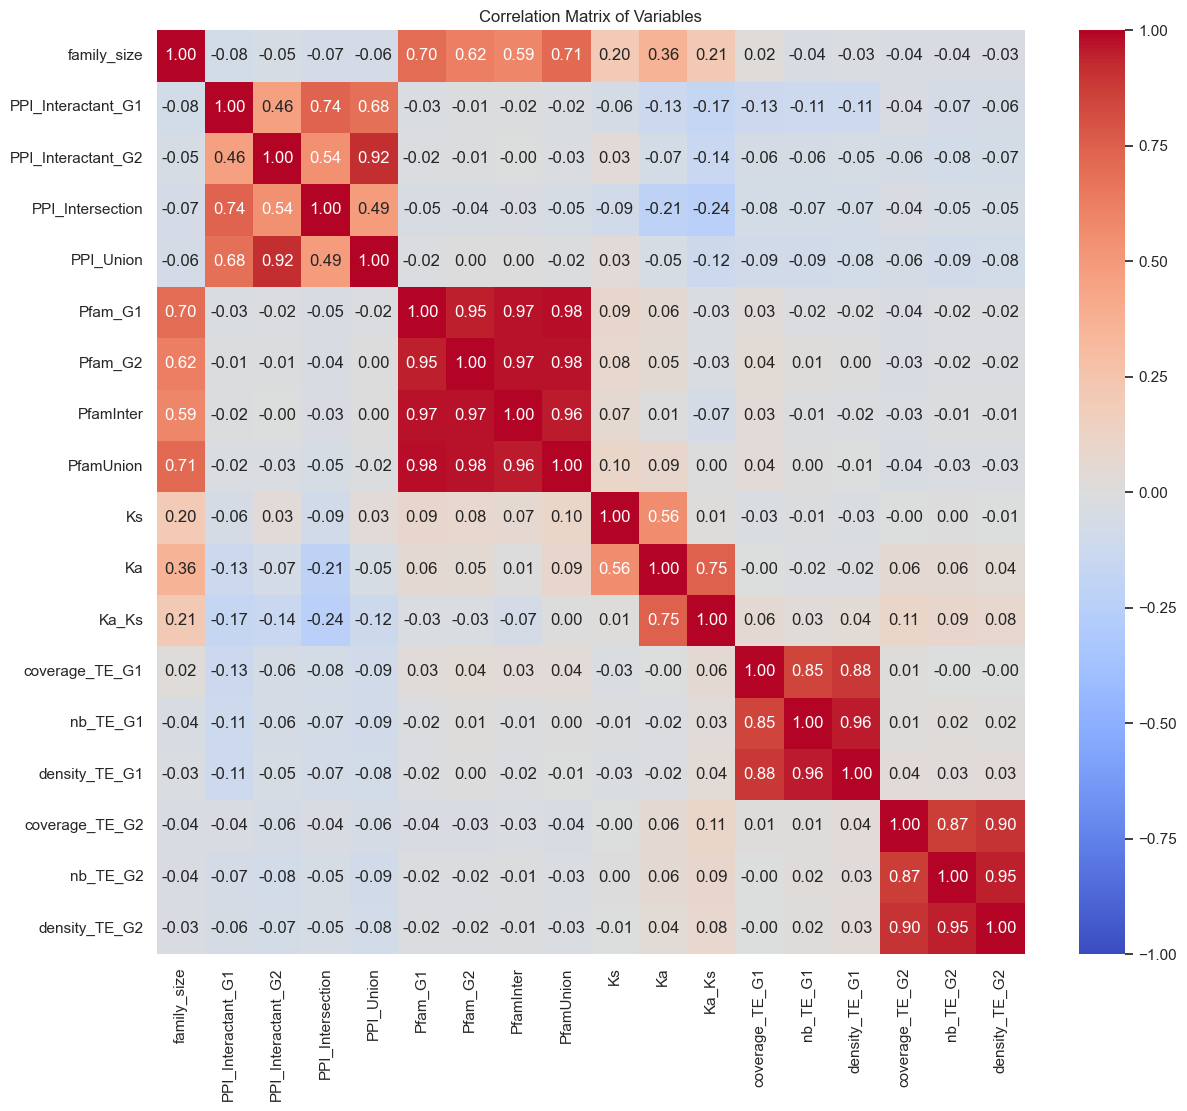

In [19]:
# I will use all the numeric features and ignore the textual ones for this first model test
# They maybe redundant so I need to check the correlation between them and the target variable (Classification1)

features_to_check = [
    'family_size', 
    'PPI_Interactant_G1', 'PPI_Interactant_G2', 'PPI_Intersection', 'PPI_Union', 
    'Pfam_G1', 'Pfam_G2', 'PfamInter', 'PfamUnion',
    'Ks', 'Ka', 'Ka_Ks', 
    'coverage_TE_G1', 'nb_TE_G1', 'density_TE_G1',
    'coverage_TE_G2', 'nb_TE_G2', 'density_TE_G2'
]

# Correlation matrix
corr_matrix = df_model[features_to_check].corr()
plt.figure(figsize=(14, 12))

# Heatmap : 
# - Dark Red = Strong Positive Correlation (It's the same thing)
# - Dark Blue = Strong Negative Correlation (It's the exact opposite)
# - White/Gray = No link (That's good!)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)

plt.title("Correlation Matrix of Variables")
plt.show()

In [20]:
# Clear strongly correlated features (correlation > 0.8 or < -0.8)
def get_redundant_features(df, threshold=0.85):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

features_to_drop = get_redundant_features(df_model[features_to_check], threshold=0.85)

print(f"Features suggested to drop due to high correlation (>0.85) : \n{features_to_drop}")

final_features = [f for f in features_to_check if f not in features_to_drop]
print(f"\nFinal list ({len(final_features)} variables) : \n{final_features}")

Features suggested to drop due to high correlation (>0.85) : 
['PPI_Union', 'Pfam_G2', 'PfamInter', 'PfamUnion', 'nb_TE_G1', 'density_TE_G1', 'nb_TE_G2', 'density_TE_G2']

Final list (10 variables) : 
['family_size', 'PPI_Interactant_G1', 'PPI_Interactant_G2', 'PPI_Intersection', 'Pfam_G1', 'Ks', 'Ka', 'Ka_Ks', 'coverage_TE_G1', 'coverage_TE_G2']


In [23]:
# X = The features | y = The target (Classification1)
X = df_model[final_features]
y = df_model['Classification1']
X.head()

,family_size,PPI_Interactant_G1,PPI_Interactant_G2,PPI_Intersection,Pfam_G1,Ks,Ka,Ka_Ks,coverage_TE_G1,coverage_TE_G2
4,4.0,6.0,4.0,1.0,1.0,1.8192,0.4049,0.222570,1.318826,5.777292
6,4.0,11.0,4.0,1.0,1.0,1.9732,0.4109,0.208240,1.318826,29.346681
15,2.0,23.0,21.0,12.0,1.0,2.3106,0.5092,0.220376,0.000000,0.000000
40,17.0,8.0,7.0,1.0,3.0,1.6167,0.3528,0.218222,15.273775,0.000000
52,17.0,0.0,7.0,0.0,3.0,8.2558,0.4092,0.049565,15.273775,0.000000


In [28]:
# Cleaning the NaN values
# For PPI or TE, if it's empty, it's often 0 (no interaction, no TE)
# For Ka/Ks, we replace with the median to avoid biasing the model
X = X.copy() # To avoid pandas warnings
X.fillna(0, inplace=True)

In [29]:
# Standardize the features (mean=0, std=1) - Important for models like Logistic Regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [31]:
# Train a simple Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [32]:
# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.7323

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68        52
         1.0       0.78      0.76      0.77        75

    accuracy                           0.73       127
   macro avg       0.72      0.73      0.72       127
weighted avg       0.73      0.73      0.73       127



C:\Users\erine\AppData\Local\Temp\ipykernel_22376\2278351547.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Feature', data=coeffs, palette='vlag')


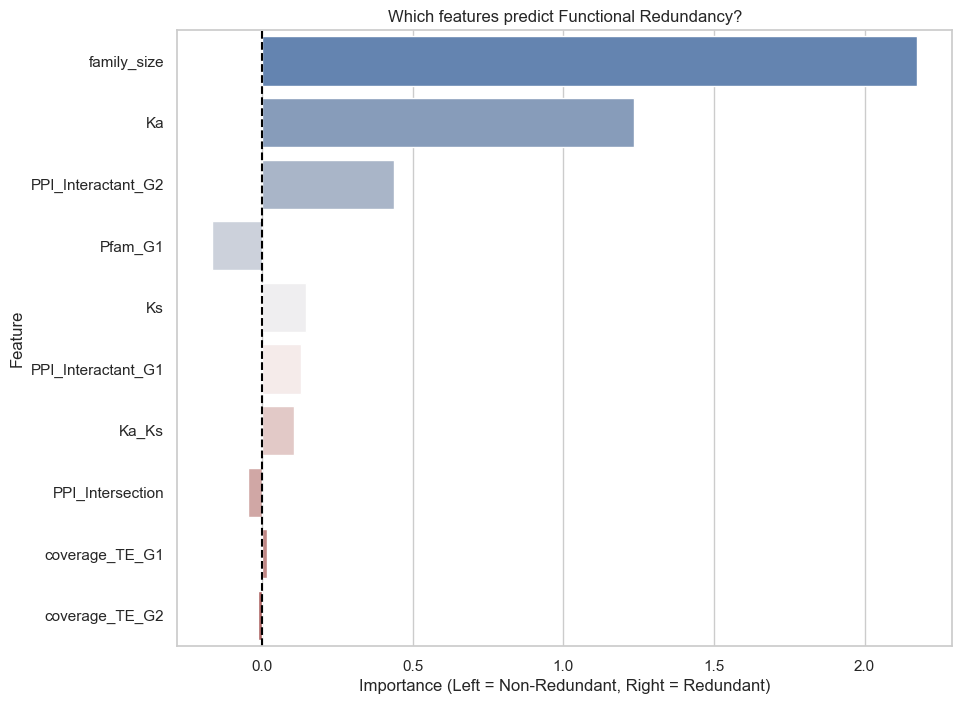

In [33]:
# Interpretation of the model (Feature Importance)
coeffs = pd.DataFrame({
    'Feature': final_features,
    'Weight': model.coef_[0],
    'Abs_Weight': abs(model.coef_[0]) # Pour trier par importance sans se soucier du signe
})
coeffs = coeffs.sort_values(by='Abs_Weight', ascending=False)

plt.figure(figsize=(10, 8))
# On colore : Rouge = For Redundancy (1), Bleu = Against Redundancy (0)
sns.barplot(x='Weight', y='Feature', data=coeffs, palette='vlag')
plt.axvline(0, color='black', linestyle='--')
plt.title("Which features predict Functional Redundancy?")
plt.xlabel("Importance (Left = Non-Redundant, Right = Redundant)")
plt.show()